In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset, random_split

import matplotlib.pyplot as plt
import numpy as np
import sentencepiece as spm
from sacrebleu import corpus_bleu

from utils import train_one_epoch, train_one_epoch_with_criterion, generate_sonnet, generate_sonnet_sampling, clean_generated_text
from model import TransformerModel

In [3]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cuda


## Load Dataset

In [4]:
X, y = torch.load('./data/sonnets_data.pt')

X

/tmp/ipykernel_6738/1759665292.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X, y = torch.load('./data/sonnets_data.pt')


tensor([[1989,   30, 3528,  ...,    0,    0,    0],
        [  24,   10,  210,  ...,    0,    0,    0],
        [  42,  210,  104,  ...,    0,    0,    0],
        ...,
        [  24,  335,  753,  ...,    0,    0,    0],
        [  24,  186,    5,  ...,    0,    0,    0],
        [  24, 2270,  240,  ...,    0,    0,    0]])

In [5]:
sp = spm.SentencePieceProcessor()
sp.load('./tokenizer/my_tokenizer.model')

True

In [6]:
dataset = TensorDataset(X, y)

n = len(dataset)
train_n = int(0.8 * n)
val_n   = int(0.1 * n)
test_n  = n - train_n - val_n

train_ds, val_ds, test_ds = random_split(dataset, [train_n, val_n, test_n],
                                         generator=torch.Generator().manual_seed(42))

batch_size = 16  # Adjust based on GPU memory

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

In [80]:
model = TransformerModel(
    vocab_size=4000, 
    seq_len=256, 
    embedding_dim=256, 
    num_heads=8, 
    num_layers=6, 
    dropout=0.1
).to(device)

optimizer = Adam(model.parameters(), lr=1e-4)

In [81]:
patience = 50
best_val_loss = float('inf')
epochs_without_improvement = 0

# Lists to track metrics
train_losses = []
val_losses = []
val_ppls = []

for epoch in range(1, 201):
    # Train
    model.train()
    train_loss = train_one_epoch(model, device, sp, optimizer, train_loader)
    train_losses.append(train_loss)
    
    # Validate
    model.eval()
    total_val_loss, total_tokens = 0.0, 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Forward pass
            output = model(x_batch)  # output shape: (batch_size, seq_len, vocab_size)

            # Flatten output and target tensors
            output = output.view(-1, output.size(-1))  # Flatten to (batch_size * seq_len, vocab_size)
            y_batch = y_batch.view(-1)  # Flatten to (batch_size * seq_len)

            # Calculate loss
            batch_loss = F.cross_entropy(output, y_batch, ignore_index=sp.pad_id()) 
            
            nonpad_mask   = (y_batch != sp.pad_id())
            batch_tokens  = nonpad_mask.sum().item()

            batch_loss_sum = batch_loss.item() * batch_tokens

            total_val_loss += batch_loss_sum
            total_tokens += batch_tokens
    
    val_loss = total_val_loss / total_tokens
    val_ppl  = np.exp(val_loss)
    val_losses.append(val_loss)
    val_ppls.append(val_ppl)
    
    print(f"Epoch {epoch:03d} — train_loss: {train_loss:.4f} | "
          f"val_loss: {val_loss:.4f} | val_ppl: {val_ppl:.2f}")
    
    if epoch % 50 == 0:
        torch.save(model.state_dict(),
                   f"./model/checkpoint_epoch_{epoch:03d}_valloss_{val_loss:.4f}.pth")
    
    # Early stop
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"\nEarly stopping at epoch {epoch} "
                  f"(no improvement in val_loss for {patience} epochs).")
            torch.save(model.state_dict(),
                   f"./model/checkpoint_epoch_{epoch:03d}_valloss_{val_loss:.4f}.pth")
            break

Epoch 001 — train_loss: 6.3697 | val_loss: 5.7876 | val_ppl: 326.23
Epoch 002 — train_loss: 5.3258 | val_loss: 5.1653 | val_ppl: 175.09
Epoch 003 — train_loss: 4.6861 | val_loss: 4.5421 | val_ppl: 93.88
Epoch 004 — train_loss: 4.3564 | val_loss: 4.3757 | val_ppl: 79.50
Epoch 005 — train_loss: 4.1863 | val_loss: 4.2942 | val_ppl: 73.28
Epoch 006 — train_loss: 4.1402 | val_loss: 4.3259 | val_ppl: 75.64
Epoch 007 — train_loss: 4.1616 | val_loss: 4.2568 | val_ppl: 70.59
Epoch 008 — train_loss: 4.0164 | val_loss: 4.1924 | val_ppl: 66.18
Epoch 009 — train_loss: 4.0175 | val_loss: 4.0350 | val_ppl: 56.54
Epoch 010 — train_loss: 3.8942 | val_loss: 4.0065 | val_ppl: 54.95
Epoch 011 — train_loss: 3.8417 | val_loss: 3.9997 | val_ppl: 54.58
Epoch 012 — train_loss: 3.8459 | val_loss: 4.0161 | val_ppl: 55.48
Epoch 013 — train_loss: 3.8563 | val_loss: 3.9519 | val_ppl: 52.03
Epoch 014 — train_loss: 3.8008 | val_loss: 3.9688 | val_ppl: 52.92
Epoch 015 — train_loss: 3.8059 | val_loss: 3.9475 | val_ppl:

In [92]:
model.eval()
total_test_loss, total_tokens = 0.0, 0
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        output = model(x_batch)
        bs, sl, vs = output.size()
        output = output.view(-1, vs)
        y_flat = y_batch.view(-1)

        batch_loss = F.cross_entropy(
            output,
            y_flat,
            ignore_index=sp.pad_id(),
            reduction='mean'
        )

        nonpad_mask  = (y_flat != sp.pad_id())
        batch_tokens = nonpad_mask.sum().item()
        batch_loss_sum = batch_loss.item() * batch_tokens

        total_test_loss += batch_loss_sum
        total_tokens    += batch_tokens

test_loss = total_test_loss / total_tokens
test_ppl  = np.exp(test_loss)
print(f"\nConjunto de teste — loss: {test_loss:.4f} | perplexity: {test_ppl:.2f}")


Conjunto de teste — loss: 1.8118 | perplexity: 6.12


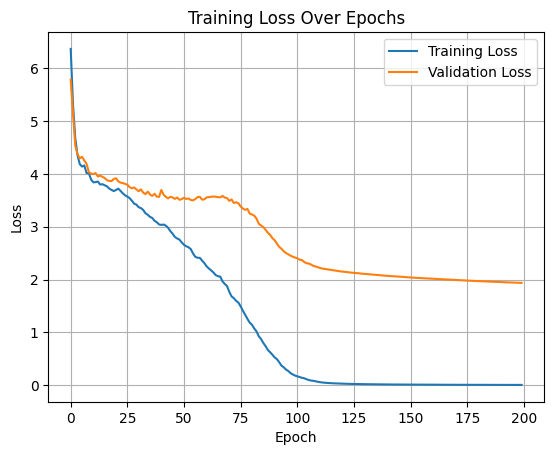

In [83]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

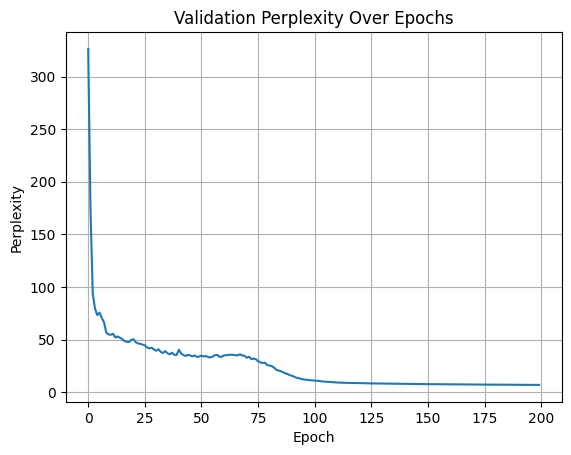

In [84]:
# Graph val_ppl
plt.plot(val_ppls, label='Validation Perplexity')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Validation Perplexity Over Epochs')
plt.grid()
plt.show()

In [85]:
model.eval()

start_text = "Shall I compare thee"
raw = generate_sonnet(model, sp, start_text, max_length=256, device='cuda')
generated_sonnet = clean_generated_text(raw, pad_token='<PAD>')
print(generated_sonnet)

Shall I compare thee I earth has been? 
 When Aprild I shouldd grants defiant Ice? 
 One claim? 
d such borrow I vain my wisdom- I am I should our destiny hurt in a reproach after myu me the seasons in this reproach Fortunad swiftly offering I should grace core 
 I should wander far from this plight? veryd past mortal boundsly known? 
 Detly reach swift peace stirmm still me how after should I am lost this lesson learn? 
 Oh, should I reproach me endure  for I am brave-worn warrior? 
 Truth. very woe, with haste, should I should falsehood, should 
 I think on me thee. 
 Of you, an unworthy dream cer at heaven'm confined bring let me I am growing. voyation of woe.


## **What if we try some different starting words?**

In [91]:
model.eval()

start_text = "Thy"
raw = generate_sonnet(model, sp, start_text, max_length=256, device='cuda')
generated_sonnet = clean_generated_text(raw, pad_token='<PAD>')
print(generated_sonnet)

Thy Th bright tears beauty end in shored  Though now lush praise for loss of all till praise, without him toxicned, denied, in tireed in an orphaned 
ed as de a? 
 Now outwards guise for wisdom past unkindness too, like dais shines innumerable endured could I then fored,d gone? 
 Fading all ailments with ardor Would ined upon my headgely the grounded inoliveded, for anew each charm of chance in this by actions wrought. 
 So injust or stain; 
 Expell? cityre outer than in suffering, now surrenders like a ghost not co in brightness twirled; Cultivate mercy for true image stirsup my fored or thrill. 
 You live in retr is all so bright soul death and I entertained no more than before? Would this lesson wishity, all, which he in


## **Using a different type of distribution**

In [104]:
model.eval()

start_text = "Thy"
raw = generate_sonnet_sampling(model, sp, start_text, max_length=256, device='cuda')
generated_sonnet = clean_generated_text(raw, pad_token='<PAD>')
print(generated_sonnet)

Thy all command image to heaven through tears gaze to heal' an wrought, every pretenseesting tohawl flow, wearyke
 Why beacon to reside, seek to Th to up time? inner self- to whispers request matter esteemed chosen to transcending 
est ardor age thee fest fast, wearyly spring's wrong granted yourself and monarchs bolded god, bare ever flworms dismiss with honor with pretense? painted the matter how My passion with grief,ly untold lack. 
 Behold advance; let that left no trace; don. ceased forth each other on both pretense-spent, by ancient thread grace only brightation endured to convey behind he forever left hold, told: "not thus, no close claimed young pursue torch begs between, address? 
 Yourself in silence, without chaotic'tis could I aged? 
 You, when the cosmos craft you keep thisch then through seared.


### BLEU Score on Test Set

In [7]:
# Load model
model = TransformerModel(
    vocab_size=4000, 
    seq_len=256, 
    embedding_dim=256, 
    num_heads=8, 
    num_layers=6, 
    dropout=0.1
).to(device)

model.load_state_dict(torch.load('./model/checkpoint_epoch_200_valloss_1.9365.pth'))

/tmp/ipykernel_6738/2330225440.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./model/checkpoint_epoch_200_valloss_1.9365.pth'))


<All keys matched successfully>

In [12]:
model.eval()

test_references = []  
test_hypotheses = []   

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        batch_size, seq_len = y_batch.size()
        for i in range(batch_size):
            # Convertemos para lista de ints
            ref_ids = y_batch[i].tolist()

            # Remover pads e truncar em <eos>
            clean_ref_ids = []
            for tid in ref_ids:
                if tid == sp.pad_id():
                    break
                if tid == sp.eos_id():
                    break
                clean_ref_ids.append(tid)

            # Decodificar em string
            ref_text = sp.decode_ids(clean_ref_ids).strip()
            test_references.append(ref_text)

        output_logits = model(x_batch)   
        
        output_ids = output_logits.argmax(dim=-1) 

        for i in range(batch_size):
            hyp_ids = output_ids[i].tolist()

            clean_hyp_ids = []
            for tid in hyp_ids:
                if tid == sp.pad_id():
                    break
                clean_hyp_ids.append(tid)

            hyp_text = sp.decode_ids(clean_hyp_ids).strip()
            test_hypotheses.append(hyp_text)


list_of_references = [test_references]

bleu = corpus_bleu(test_hypotheses, list_of_references)

print(test_hypotheses[:5])
print(test_references[:5])
print(f"BLEU score (corpus) = {bleu.score:.2f}")

["ould be and you to grasp my plightal gleam, <LINE> When eyes's gallery?,s trans and flows my woe, <LINE> And should you feel of this season skill Of<LINE> Of noble, left in my wisdom to human you as; <LINE> Stealing real to the splendor of marks, <LINE> Though they may clea in the face of days, <LINE> Ha your for the world of corrupt, <LINE> In every of the love that left vibrant they. <LINE> Then thus on through fire, so ⁇  fortress: <LINE> ATruth.d notes <LINE>,, drawe the sovereign's sting, <LINE> Ahest woes, this para heart might remain <LINE> To stand among the lens of,ic s wegiding. <LINE> Yet, as he, bereft and grow woo,, <LINE> I'll restore forever for love, theirs for their trust false <LINE> <LINE><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD> ⁇  ⁇ 

# **Valorization of Line Breaks and Rhymes**

What if we insert in the dataset tokens for the rhymes and give them a bigger weight?

In [15]:
model = TransformerModel(
    vocab_size=4000, 
    seq_len=277, # This max len comes from the previous notebook
    embedding_dim=256,
    num_heads=8, 
    num_layers=6, 
    dropout=0.1
).to(device)

optimizer = Adam(model.parameters(), lr=1e-4)

In [13]:
sp = spm.SentencePieceProcessor()
sp.load('./tokenizer/my_rhyme_tokenizer.model')

True

In [14]:
X, y = torch.load('./data/sonnets_rhymes_data.pt')

X

/tmp/ipykernel_6738/2971999727.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X, y = torch.load('./data/sonnets_rhymes_data.pt')


tensor([[1993,   37, 3529,  ...,    4,    4,    4],
        [  31,   17,  214,  ...,    4,    4,    4],
        [  49,  214,  113,  ...,    4,    4,    4],
        ...,
        [  31,  340,  717,  ...,    4,    4,    4],
        [  31,  194,   12,  ...,    4,    4,    4],
        [  31, 2269,  243,  ...,    4,    4,    4]])

In [15]:
dataset = TensorDataset(X, y)

n = len(dataset)
train_n = int(0.8 * n)
val_n   = int(0.1 * n)
test_n  = n - train_n - val_n

train_ds, val_ds, test_ds = random_split(dataset, [train_n, val_n, test_n],
                                         generator=torch.Generator().manual_seed(42))

batch_size = 16  # Adjust based on GPU memory

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

In [16]:
vocab_size = sp.get_piece_size()
weights = torch.ones(vocab_size, device=device)
line_token_id = sp.piece_to_id('<LINE>')
weights[line_token_id] = 5.0  # adjust multiplier as you like

rhyme_classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
for rhyme in rhyme_classes:
    token = f"<rhyme_{rhyme}>"
    token_id = sp.piece_to_id(token)
    weights[token_id] = 5.0  # same multiplier or adjust individually if desired

# Define loss with weights and ignore pad token
criterion = nn.CrossEntropyLoss(weight=weights, ignore_index=sp.pad_id())

In [20]:
patience = 50
best_val_loss = float('inf')
epochs_without_improvement = 0

# Lists to track metrics
train_losses = []
val_losses = []
val_ppls = []

for epoch in range(1, 201):
    # Train
    model.train()
    train_loss = train_one_epoch_with_criterion(model, optimizer, device, criterion, train_loader)
    train_losses.append(train_loss)
    
    # Validate
    model.eval()
    total_val_loss, total_tokens = 0.0, 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Forward pass
            output = model(x_batch)  # output shape: (batch_size, seq_len, vocab_size)

            # Flatten output and target tensors
            output = output.view(-1, output.size(-1))  # Flatten to (batch_size * seq_len, vocab_size)
            y_batch = y_batch.view(-1)  # Flatten to (batch_size * seq_len)

            # Calculate loss
            batch_loss = criterion(output, y_batch) 
            
            nonpad_mask   = (y_batch != sp.pad_id())
            batch_tokens  = nonpad_mask.sum().item()

            batch_loss_sum = batch_loss.item() * batch_tokens

            total_val_loss += batch_loss_sum
            total_tokens += batch_tokens
    
    val_loss = total_val_loss / total_tokens
    val_ppl  = np.exp(val_loss)
    val_losses.append(val_loss)
    val_ppls.append(val_ppl)
    
    print(f"Epoch {epoch:03d} — train_loss: {train_loss:.4f} | "
          f"val_loss: {val_loss:.4f} | val_ppl: {val_ppl:.2f}")
    
    if epoch % 50 == 0:
        torch.save(model.state_dict(),
                   f"./model/rhyme_checkpoint_epoch_{epoch:03d}_valloss_{val_loss:.4f}.pth")
    
    # Early stop
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        #if epochs_without_improvement >= patience:
        #    print(f"\nEarly stopping at epoch {epoch} "
        #          f"(no improvement in val_loss for {patience} epochs).")
        #    torch.save(model.state_dict(),
        #           f"./model/rhyme_checkpoint_epoch_{epoch:03d}_valloss_{val_loss:.4f}.pth")
        #    break

Epoch 001 — train_loss: 5.9597 | val_loss: 4.8977 | val_ppl: 133.98
Epoch 002 — train_loss: 4.5174 | val_loss: 4.2680 | val_ppl: 71.38
Epoch 003 — train_loss: 4.0421 | val_loss: 3.8921 | val_ppl: 49.01
Epoch 004 — train_loss: 3.7076 | val_loss: 3.6137 | val_ppl: 37.10
Epoch 005 — train_loss: 3.4666 | val_loss: 3.4170 | val_ppl: 30.48
Epoch 006 — train_loss: 3.2759 | val_loss: 3.2500 | val_ppl: 25.79
Epoch 007 — train_loss: 3.1163 | val_loss: 3.1283 | val_ppl: 22.84
Epoch 008 — train_loss: 3.0031 | val_loss: 3.0499 | val_ppl: 21.11
Epoch 009 — train_loss: 2.9285 | val_loss: 2.9974 | val_ppl: 20.03
Epoch 010 — train_loss: 2.8751 | val_loss: 2.9628 | val_ppl: 19.35
Epoch 011 — train_loss: 2.8339 | val_loss: 2.9305 | val_ppl: 18.74
Epoch 012 — train_loss: 2.7970 | val_loss: 2.9080 | val_ppl: 18.32
Epoch 013 — train_loss: 2.7672 | val_loss: 2.8827 | val_ppl: 17.86
Epoch 014 — train_loss: 2.7384 | val_loss: 2.8618 | val_ppl: 17.49
Epoch 015 — train_loss: 2.7096 | val_loss: 2.8473 | val_ppl: 

In [21]:
model.eval()
total_test_loss, total_tokens = 0.0, 0
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        output = model(x_batch)
        bs, sl, vs = output.size()
        output = output.view(-1, vs)
        y_flat = y_batch.view(-1)

        batch_loss = F.cross_entropy(
            output,
            y_flat,
            ignore_index=sp.pad_id(),
            reduction='mean'
        )

        nonpad_mask  = (y_flat != sp.pad_id())
        batch_tokens = nonpad_mask.sum().item()
        batch_loss_sum = batch_loss.item() * batch_tokens

        total_test_loss += batch_loss_sum
        total_tokens    += batch_tokens

test_loss = total_test_loss / total_tokens
test_ppl  = np.exp(test_loss)
print(f"\nConjunto de teste — loss: {test_loss:.4f} | perplexity: {test_ppl:.2f}")


Conjunto de teste — loss: 4.2952 | perplexity: 73.35


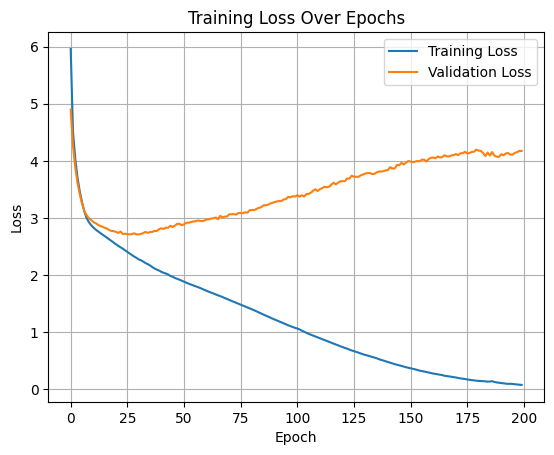

In [22]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

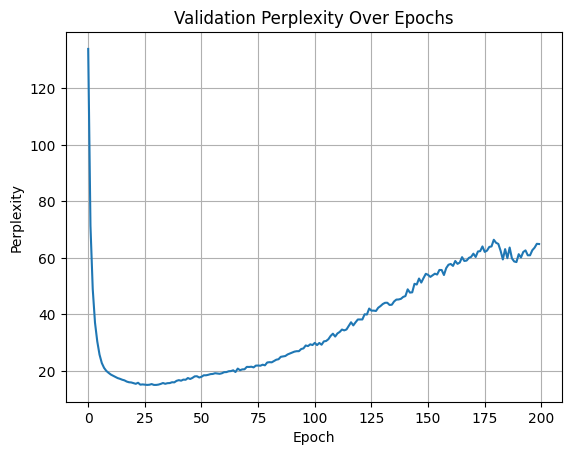

In [23]:
# Graph val_ppl
plt.plot(val_ppls, label='Validation Perplexity')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Validation Perplexity Over Epochs')
plt.grid()
plt.show()

In [24]:
model.eval()

start_text = "Shall I compare thee"
raw = generate_sonnet(model, sp, start_text, max_length=256, device='cuda')
generated_sonnet = clean_generated_text(raw, pad_token='<PAD>')
print(generated_sonnet)

Shall I compare theend own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own own o

In [25]:
model.eval()

start_text = "Thy"
raw = generate_sonnet(model, sp, start_text, max_length=256, device='cuda')
generated_sonnet = clean_generated_text(raw, pad_token='<PAD>')
print(generated_sonnet)

Thy brand wave gripy left fierce;;;; f;;;;; you;; you;;;;;;;;;;;;;;;;;;;;;;;;;;; you;;;;;; you;;;;; you;;;; who; you you; you;; you;;;;;;;;;;;;;;;;;;;;;;;;;;;; you;;;;;;;;;;;;;; you;;; you;; you you you you; you you; you you you you; you you; you you you you; you you you you;; you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you


In [26]:
model.eval()

start_text = "Thy"
raw = generate_sonnet_sampling(model, sp, start_text, max_length=256, device='cuda')
generated_sonnet = clean_generated_text(raw, pad_token='<PAD>')
print(generated_sonnet)

Thyers harm resemble who held in in in in in in in in in in in in in in in in before in in in in don in ben in together in in in in in though in immortalteous in in in doni deedour in holding in met in in in in pro in in in in in before inelude draw in captur draw in both did in in in before in pierce in in in in Carrie in in in in in an in in in in in in in inected in in in in though in in both in in in after in they are in slumber reveal in in smart their draw in take in in in in before in in cannot in before in in in in pro left in flare in ensnared in in pro left in capture in mis in there we cannot in in in skies in in both take in in in in in world in in in in inq are in in in before in in in in in in in in in in in genuine in in left in pro in in lifeless in pro in in in in in or in their in in in memories was in in in pro in in her in in in in in in in in in in in or or in her in in in in they in in semblance in in in shin in in mis in their in


### BLEU Score on Test Set

In [19]:
# Load model
model = TransformerModel(
    vocab_size=4000, 
    seq_len=277, # This max len comes from the previous notebook
    embedding_dim=256,
    num_heads=8, 
    num_layers=6, 
    dropout=0.1
).to(device)

model.load_state_dict(torch.load('./model/rhyme_checkpoint_epoch_200_valloss_4.1735.pth'))

/tmp/ipykernel_6738/1930464033.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./model/rhyme_checkpoint_epoch_200_valloss_4.1735.pth')

<All keys matched successfully>

In [20]:
model.eval()

test_references = []  
test_hypotheses = []   

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        batch_size, seq_len = y_batch.size()
        for i in range(batch_size):
            # Convertemos para lista de ints
            ref_ids = y_batch[i].tolist()

            # Remover pads e truncar em <eos>
            clean_ref_ids = []
            for tid in ref_ids:
                if tid == sp.pad_id():
                    break
                if tid == sp.eos_id():
                    break
                clean_ref_ids.append(tid)

            # Decodificar em string
            ref_text = sp.decode_ids(clean_ref_ids).strip()
            test_references.append(ref_text)

        output_logits = model(x_batch)   
        
        output_ids = output_logits.argmax(dim=-1) 

        for i in range(batch_size):
            hyp_ids = output_ids[i].tolist()

            clean_hyp_ids = []
            for tid in hyp_ids:
                if tid == sp.pad_id():
                    break
                clean_hyp_ids.append(tid)

            hyp_text = sp.decode_ids(clean_hyp_ids).strip()
            test_hypotheses.append(hyp_text)


list_of_references = [test_references]

bleu = corpus_bleu(test_hypotheses, list_of_references)

print(test_hypotheses[:5])
print(test_references[:5])
print(f"BLEU score (corpus) = {bleu.score:.2f}")

["ould my;s are live of visional , <rhyme_A> <LINE> When such,s ofness s of, night the, release; ever<rhyme_B> t Andlock fray are to this impur shoulder wearW <LINE> Ou time or sweet  the branches. human it remain. <rhyme_B>  ⁇  But of' adore grace true of valor,, <rhyme_C> <LINE> Aough  find fall, the sight of wander. <rhyme_D> <LINE> Sweet false grace the most  watch, <rhyme_C> <LINE> In gardens, sight clock they trace filled made light <rhyme_D> <LINE> But in myly denial of in pure care glow <LINE> <rhyme_E> NoI ofd lose seek<rhyme_F>in, where of' world ors delights <rhyme_F> <LINE> A gem, than, the bloom heart be  <rhyme_E> <LINE> To make,ing spoiling. worldic <rhyme_F>able Timeade train <rhyme_F> <LINE> For who as do forever un to I verse to, <rhyme_G> <LINE> I've this beyond name myself initia and monuments  thee treasure,  <rhyme_G><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD

### Awful overfitting alert!

Let's continue with our first idea for the lightweight model